#Cleaning

In [ ]:
import os
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from google.colab import drive

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def clean_text(text):
    """Cleans text while preserving readability and structure."""
    text = text.lower().strip()  # Convert to lowercase and remove leading/trailing spaces
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    text = re.sub(r'[^\w\s.,!?-]', '', text)  # Keep basic punctuation
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'--+|\.{2,}|\s?_\s?', ' ', text)  # Remove multiple dashes/underscores
    text = re.sub(r'\b(Links|links)\b', '', text)

    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)  # Tokenize text
    words = [word for word in words if word not in stop_words]  # Remove stopwords

    return ' '.join(words)

def extract_text_after_svm(article):
    """Does nothing"""
    return article

def process_articles(base_path, output_path):
    """Loads, cleans, and saves each news article as a separate CSV file."""

    for year in range(2002, 2024):  # Loop through years
        folder_path = os.path.join(base_path, str(year))
        if not os.path.exists(folder_path):
            print(f"Skipping missing folder: {folder_path}")
            continue

        # Create output folder for the year
        year_folder = os.path.join(output_path, str(year))
        os.makedirs(year_folder, exist_ok=True)

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)

            with open(file_path, 'r', encoding='latin-1') as f:
                content = f.read()
                sections = re.split(r'-{5,}|_{5,}', content)  # Split articles

                # Remove sections containing "Search Strategy"
                filtered_sections = [section for section in sections if "Search Strategy" not in section]

                # Keep only the content after "SVM score" and clean
                cleaned_articles = [clean_text(extract_text_after_svm(article))
                                    for article in filtered_sections if extract_text_after_svm(article)]

                if cleaned_articles:
                    csv_filename = os.path.splitext(filename)[0] + ".csv"
                    output_file = os.path.join(year_folder, csv_filename)

                    df = pd.DataFrame({'year': [year] * len(cleaned_articles), 'text': cleaned_articles})
                    df.to_csv(output_file, index=False, encoding='utf-8')

                    print(f"Saved: {output_file} ({len(df)} articles)")

# Define input and output paths
base_path = "/content/drive/MyDrive/MIC_Dataset"  # Update with actual data path
output_path = "/content/drive/MyDrive/MIC_New_Cleaned"  # Update with actual output path

# Process and save articles
process_articles(base_path, output_path)


This Cleaned the text for labeling

#Labeling the cleaned data based on regex

In [ ]:
import os
import pandas as pd
import re
import spacy
from google.colab import drive
from word2number import w2n
from dateutil import parser

nlp = spacy.load('en_core_web_sm')

def convert_word_numbers(text):
    """Converts word numbers like 'two' to digits."""
    try:
        return str(w2n.word_to_num(text))
    except ValueError:
        return text

# Function to extract features from text
def extract_features(article):

    date = None
    day = month = year = None

    date_match = re.search(
    r'\b(\d{4}[-/]?\d{2}[-/]?\d{2}|\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\w+\s+\d{1,2},?\s+\d{4})\b',
    article
      ) # Extract format dates


    if date_match:
        try:
            parsed = parser.parse(date_match.group(1))
            day = parsed.day
            month = parsed.month
            year = parsed.year
        except:
            pass


    article = re.sub(r'svm score \d+(\.\d+)?', '', article)

    article = re.sub(
        r'\b(one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|twenty|thirty|forty|fifty|sixty|seventy|eighty|ninety|hundred|thousand)\b',
        lambda x: convert_word_numbers(x.group()), article)

    fatality_pattern = r'''
    (?:
        (?:kill(?:ed)?|dead|casualties|fatalities|slain|deaths|murdered|massacred|perished)
        (?:\s+\w+){0,3}?\s+(\d{1,3}(?:,\d{3})*|\d+)\b
    )
    |
    (?:
        \b(\d{1,3}(?:,\d{3})*|\d+)\s+(?:\w+\s+){0,3}?
        (?:kill(?:ed)?|dead|casualties|fatalities|slain|deaths|murdered|massacred|perished)
    )
    '''
    matches = re.findall(fatality_pattern, article, re.IGNORECASE | re.VERBOSE)

    numbers = []
    for group in matches:
        for num in group:
            if num:
                num_clean = num.replace(',', '')
                if num_clean.isdigit():
                    val = int(num_clean)

                    # Exclude 4-digit years (except 2000) to avoid wrong fatalities extraction
                    if val != 2000 and 1975 <= val <= 2023:
                        continue

                    # Skip things like "1,500-year-old"
                    if re.search(rf'{num.strip()}[-\s]?(year|year-old|years)\b', article, re.IGNORECASE):
                        continue

                    numbers.append(val)

    filtered = [n for n in numbers if n < 100000]

    min_fatalities = min(filtered) if filtered else 0
    max_fatalities = max(filtered) if filtered else 0

    # Countries - NER
    # Normalize country names

    doc = nlp(article)
    ner_countries = {ent.text.lower().strip() for ent in doc.ents if ent.label_ == "GPE"}

    # Abbreviations: match pairs like afg-chn or usa-iraq
    abbr_matches = re.findall(r'\b([a-z]{3})[-/]([a-z]{3})\b', article.lower())
    abbr_countries = set()
    for a1, a2 in abbr_matches:
        if a1 in state_abbr_to_name:
            abbr_countries.add(state_abbr_to_name[a1])
        if a2 in state_abbr_to_name:
            abbr_countries.add(state_abbr_to_name[a2])

    # Manual alias-based matching
    article_lower = article.lower()
    alias_to_standard = {
        'us': 'united states of america',
        'u.s.': 'united states of america',
        'usa': 'united states of america',
        'u.s.a.': 'united states of america',
        'united states': 'united states of america',
        'china': 'china',
        'afghanistan': 'afghanistan',
        'cuba': 'cuba',
    }

    alias_matches = {
        std for alias, std in alias_to_standard.items()
        if re.search(r'\b' + re.escape(alias) + r'\b', article_lower)
    }

    # Union of all matches
    all_matched = ner_countries.union(abbr_countries).union(alias_matches)

    # Final filtering
    matched_countries = [
        c.title() for c in all_matched if c in valid_country_names
    ]

    return day, month, year, min_fatalities, max_fatalities, ', '.join(sorted(set(matched_countries))) if matched_countries else None


# Apply feature extraction to processed CSV files
def process_extracted_features(processed_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(processed_folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(processed_folder, file_name)
            df = pd.read_csv(file_path)

            df[['day', 'month', 'year', 'min_fatalities', 'max_fatalities', 'countries']] = df['text'].apply(
                lambda x: pd.Series(extract_features(str(x)))
            )

            # Convert to Int64 (nullable int type that allows NaN)
            df['day'] = df['day'].astype('Int64')
            df['month'] = df['month'].astype('Int64')
            df['year'] = df['year'].astype('Int64')
            df['min_fatalities'] = df['min_fatalities'].astype('Int64')
            df['max_fatalities'] = df['max_fatalities'].astype('Int64')

            df = df[['text','month', 'day', 'year', 'min_fatalities', 'max_fatalities', 'countries']]

            output_path = os.path.join(output_folder, file_name)
            df.to_csv(output_path, index=True)
            print(f"Saved processed file: {output_path}")



processed_folder = "/content/drive/MyDrive/MIC_New_Cleaned"  # Folder containing processed CSVs
output_folder = "/content/drive/MyDrive/MIC_Correct_Label"  # Folder to save extracted features

process_extracted_features(processed_folder, output_folder)


This saved labels in csv files

Columns: 'text',	'month',	'day',	'year',	'min_fatalities',	'max_fatalities',	'countries'

Image: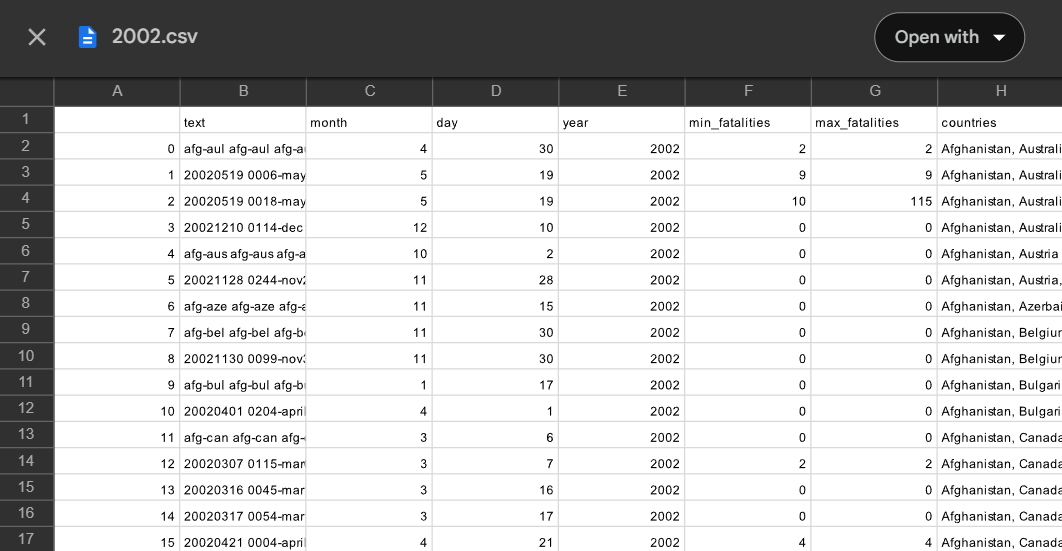

#Tokenizing

In [ ]:
import pandas as pd
import spacy
from datetime import datetime
import re
from sklearn.model_selection import train_test_split
import os

# Load spaCy for text processing
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    """Basic text cleaning function"""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

def extract_date_components(row):
    try:
        year = int(row['year'])
        month = int(row['month'])
        day = int(row['day'])
        return datetime(year, month, day).strftime('%Y-%m-%d')
    except:
        return None

def preprocess_data(df):
    """Main preprocessing function"""

    df['cleaned_text'] = df['text'].apply(clean_text)
    df['full_date'] = df.apply(extract_date_components, axis=1)
    df = df.dropna(subset=['cleaned_text', 'full_date', 'min_fatalities', 'max_fatalities', 'countries'])

    df['min_fatalities'] = df['min_fatalities'].astype(int)
    df['max_fatalities'] = df['max_fatalities'].astype(int)

    return df


folder_path = '/content/drive/MyDrive/MIC_Correct_Label'
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Combine
df_list = [pd.read_csv(file) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

processed_df = preprocess_data(df)

# Split data
train_df, eval_df = train_test_split(processed_df, test_size=0.2, random_state=42)

In [ ]:
# Using Sample
train_df = train_df.sample(frac=0.5, random_state=42)
eval_df = eval_df.sample(frac=0.5, random_state=42)

Preparing Labels

In [ ]:
import re
from dateutil import parser
from word2number import w2n
from google.colab import drive

nlp = spacy.load("en_core_web_sm")

alias_to_standard = {
    'us': 'united states of america',
    'u.s.': 'united states of america',
    'usa': 'united states of america',
    'u.s.a.': 'united states of america',
    'united states': 'united states of america',
    'china': 'china',
    'afghanistan': 'afghanistan',
    'cuba': 'cuba',
}

def convert_number_to_words(number):
    """Convert number to word if possible (e.g. 4 -> 'four')."""
    try:
        return w2n.word_to_num(str(number))
    except:
        return None

def find_all_spans(text, target):
    matches = [m for m in re.finditer(re.escape(target.lower()), text.lower())]
    return [(m.start(), m.end()) for m in matches]

def prepare_labels(text, date, min_fat, max_fat, countries):
    doc = nlp(text)
    labels = ["O"] * len(doc)

    def match_and_tag(value, tag):
        for span_start, span_end in find_all_spans(text, value):
            span = doc.char_span(span_start, span_end)
            if span:
                labels[span.start] = f"B-{tag}"
                for i in range(span.start + 1, span.end):
                    labels[i] = f"I-{tag}"

    #DATE tagging
    try:
        parsed = datetime.strptime(date, "%Y-%m-%d")
        date_variants = [
            parsed.strftime("%B %d, %Y"),
            parsed.strftime("%b %d, %Y"),
            parsed.strftime("%d %B %Y"),
            parsed.strftime("%d %b %Y"),
            parsed.strftime("%B %d %Y"),
            parsed.strftime("%b %d %Y"),
            parsed.strftime("%Y-%m-%d"),
            parsed.strftime("%Y%m%d"),
            parsed.strftime("%d%B%Y"),
            parsed.strftime("%d%b%Y"),
        ]
        for date_str in date_variants:
            match_and_tag(date_str, "DATE")
    except Exception as e:
        pass

    # MIN/MAX Fatalities tagging
    for number, tag in [(min_fat, "MIN_FAT"), (max_fat, "MAX_FAT")]:
        if pd.isna(number):
            continue
        str_num = str(int(number))
        word_num = None
        try:
            word_num = w2n.word_to_num(str_num)
        except:
            pass

        match_and_tag(str_num, tag)
        try:
            word = list(w2n.american_number_system.keys())[int(str_num)]
            match_and_tag(word, tag)
        except:
            pass

    # COUNTRY tagging
    if countries and isinstance(countries, str):
        for country in countries.split(","):
            country = country.strip()
            if country:
                match_and_tag(country, "COUNTRY")

    return labels

# Prepare training data
train_data = []
for _, row in train_df.iterrows():
    labels = prepare_labels(
        row['cleaned_text'],
        row['full_date'],
        row['min_fatalities'],
        row['max_fatalities'],
        row['countries']
    )
    train_data.append({
        "text": row['cleaned_text'],
        "full_date": row['full_date'],
        "min_fatalities": row['min_fatalities'],
        "max_fatalities": row['max_fatalities'],
        "countries": row['countries'],
        "labels": labels
    })

# evaluation data
eval_data = []
for _, row in eval_df.iterrows():
    labels = prepare_labels(
        row['cleaned_text'],
        row['full_date'],
        row['min_fatalities'],
        row['max_fatalities'],
        row['countries']
    )
    eval_data.append({
        "text": row['cleaned_text'],
        "labels": labels
    })

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
eval_dataset = Dataset.from_pandas(pd.DataFrame(eval_data))

train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
eval_tokenized = eval_dataset.map(tokenize_and_align_labels, batched=True)

# train_tokenized gets ready here for training

train_dataset.to_pandas().to_csv('/content/drive/MyDrive/labeled_zeroOne/train_label_dataset.csv', index=False)
train_tokenized.to_pandas().to_csv('/content/drive/MyDrive/labeled_zeroOne/train_tokenized_label_dataset.csv', index=False)

eval_dataset.to_pandas().to_csv('/content/drive/MyDrive/labeled_zeroOne/eval_label_dataset.csv', index=False)
eval_tokenized.to_pandas().to_csv('/content/drive/MyDrive/labeled_zeroOne/eval_tokenized_label_dataset.csv', index=False)

#Loading Tokenzied Data

In [ ]:
import pandas as pd
from datasets import Dataset

df_train = pd.read_csv('/content/drive/MyDrive/labeled_zeroOne/train_label_dataset.csv')
train_data = Dataset.from_pandas(df_train)
# Fix label format
for sample in train_data:
    if isinstance(sample['labels'], (np.ndarray,)):
        sample['labels'] = sample['labels'].tolist()
    elif isinstance(sample['labels'], str):
        sample['labels'] = sample['labels'].replace("'", "").replace("[", "").replace("]", "").split()


df_cleaned = pd.DataFrame(train_data)
columns_to_remove = ['full_date', 'min_fatalities', 'max_fatalities', 'countries']
df_cleaned = df_cleaned.drop(columns=[col for col in columns_to_remove if col in df_cleaned.columns])

df_cleaned.to_csv('/content/drive/MyDrive/clean_labeled_zeroOne/train_label_dataset.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset

df_train = pd.read_csv('/content/drive/MyDrive/labeled_zeroOne/train_tokenized_label_dataset.csv')
train_tokenized = Dataset.from_pandas(df_train)

df_train_tokenized = train_tokenized.to_pandas()

columns_to_drop = ['full_date', 'min_fatalities', 'max_fatalities', 'countries']
# Drop unnecessary columns
df_train_tokenized = df_train_tokenized.drop(columns=[col for col in columns_to_drop if col in df_train_tokenized.columns])

# clean string format
list_cols = ['input_ids', 'attention_mask', 'token_type_ids', 'labels', 'offset_mapping']
for col in list_cols:
    if col in df_train_tokenized.columns:
        df_train_tokenized[col] = df_train_tokenized[col].apply(lambda x: str(x).replace('\n', ' '))

df_train_tokenized.to_csv('/content/drive/MyDrive/clean_labeled_zeroOne/train_tokenized_label_dataset_clean.csv', index=False)

Loading data

In [ ]:
import pandas as pd
from datasets import Dataset

def safe_label_parse(label_string):
    return label_string.strip("[]").replace("'", "").split()

df = pd.read_csv('/content/drive/MyDrive/clean_labeled_zeroOne/train_label_dataset.csv')

df['labels'] = df['labels'].apply(safe_label_parse)

train_dataset = Dataset.from_pandas(df)

In [ ]:
import pandas as pd
from datasets import Dataset
import ast
import re

def parse_list(s):
    s = s.strip("[] ")
    if ',' in s:
        return list(map(int, s.split(',')))
    else:
        return list(map(int, s.split()))

def parse_offset_mapping(s):

    matches = re.findall(r'array\(\[(\d+),\s*(\d+)\]\)', s)
    return [[int(a), int(b)] for a, b in matches]


df_tokenized = pd.read_csv('/content/drive/MyDrive/clean_labeled_zeroOne/train_tokenized_label_dataset_clean.csv')

columns_to_drop = ['full_date', 'min_fatalities', 'max_fatalities', 'countries']
df_tokenized = df_tokenized.drop(columns=[col for col in columns_to_drop if col in df_tokenized.columns])

for col in ['input_ids', 'attention_mask', 'token_type_ids', 'labels']:
    if col in df_tokenized.columns:
        df_tokenized[col] = df_tokenized[col].astype(str).str.replace('\n', ' ', regex=False)
        df_tokenized[col] = df_tokenized[col].apply(parse_list)

if 'offset_mapping' in df_tokenized.columns:
    df_tokenized['offset_mapping'] = df_tokenized['offset_mapping'].astype(str).str.replace('\n', ' ', regex=False)
    df_tokenized['offset_mapping'] = df_tokenized['offset_mapping'].apply(parse_offset_mapping)

df_tokenized = df_tokenized.reset_index(drop=True)

train_tokenized = Dataset.from_pandas(df_tokenized)

train_tokenized[0]

#Tokenized Data:
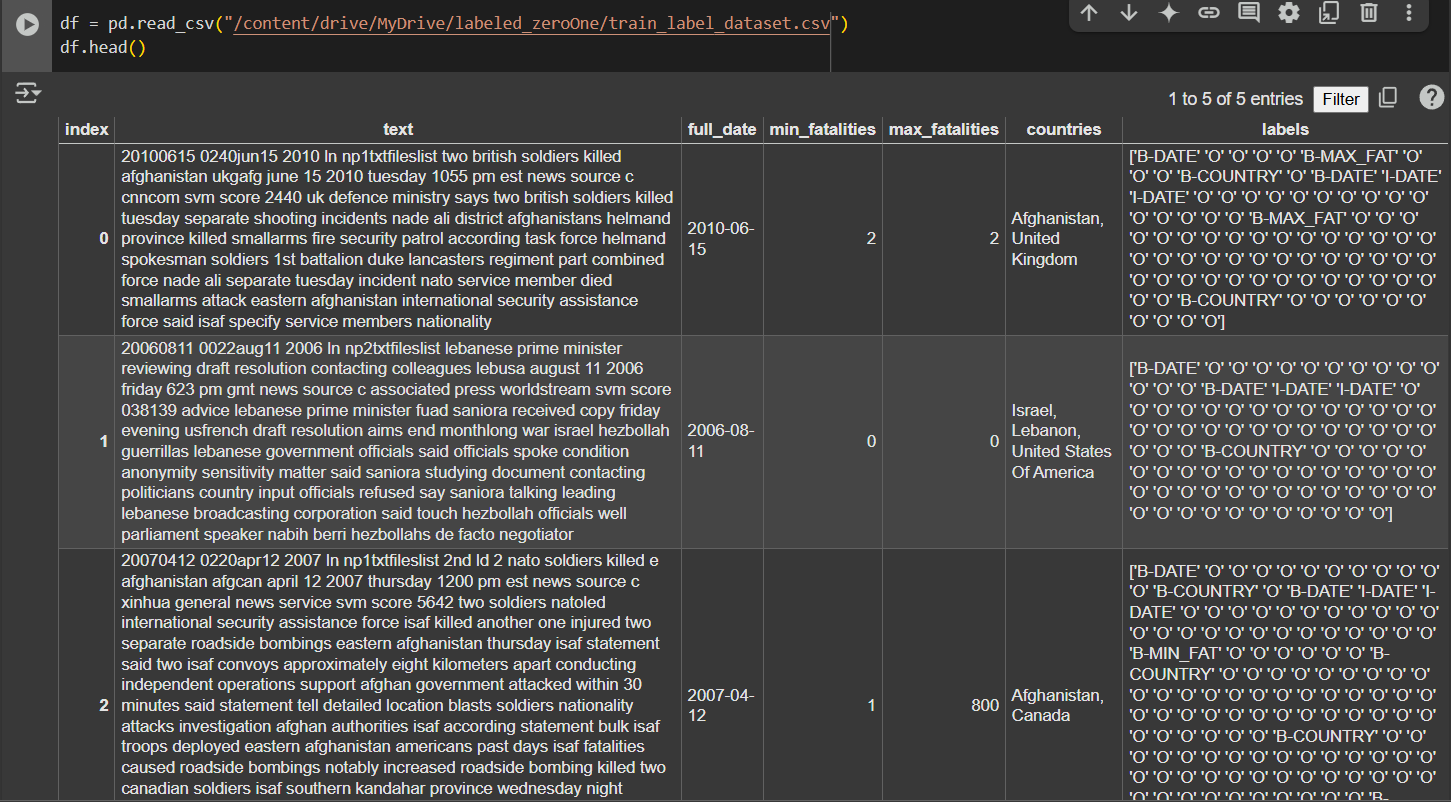

#Tokenized Label Dataset:
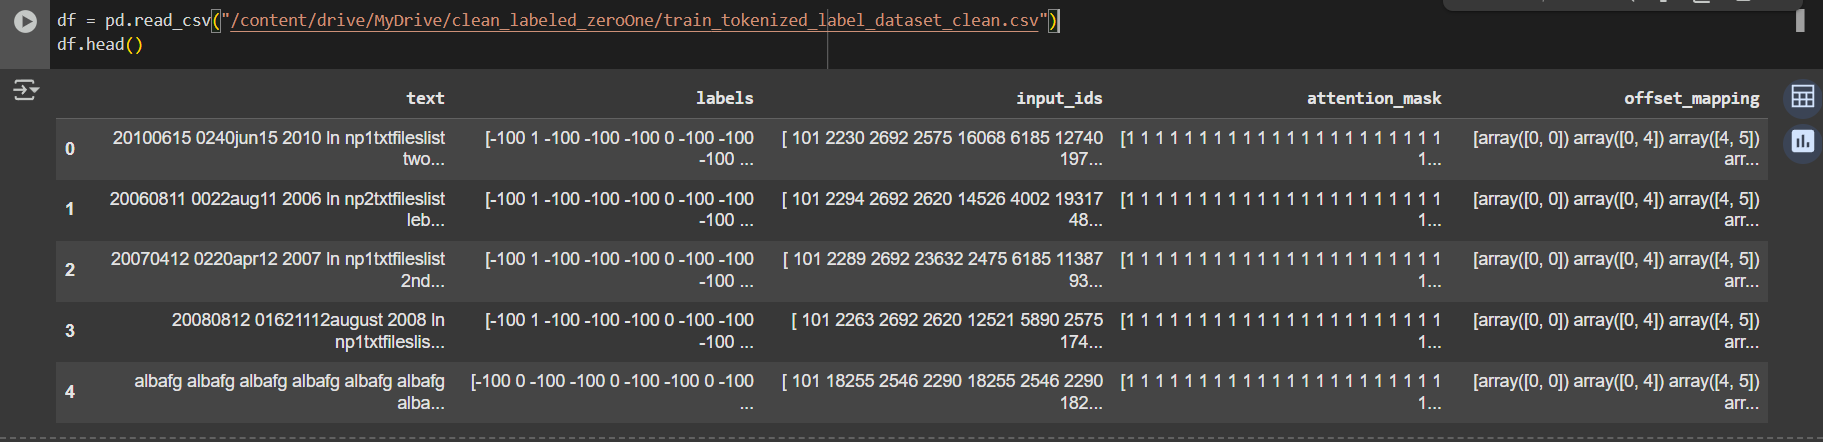